# Basic Design

**Question:**
Take a look at the map and derive distances (min, max) and angles (horizontal and vertical).

**Question:**
Make a drawing showing the center lines and edge angles. 

In [1]:
import math
import folium
import numpy as np
from geopy.distance import distance

In [2]:
antenna_building_height_m = 20

antenna_coordinates = [51.225779846347535, 4.400503131269632]
min_site_coordinates = [51.227090, 4.393261]
max_site_coordinates = [51.227990333375544, 4.389441701586266]
min_site_north_coordinates = [51.22979961685109, 4.394331930457293]
min_site_south_coordinates = [51.22466615115592, 4.391886179162105]

In [3]:
map = folium.Map(location=min_site_coordinates, zoom_start=15)

antenna_marker = folium.Marker(location=antenna_coordinates, popup="antenna")
min_site_marker = folium.Marker(location=min_site_coordinates, popup="min site")
max_site_marker = folium.Marker(location=max_site_coordinates, popup="max site")
min_site_north_marker = folium.Marker(location=min_site_north_coordinates, popup="min site north")
min_site_south_marker = folium.Marker(location=min_site_south_coordinates, popup="min site south")

antenna_marker.add_to(map)
min_site_marker.add_to(map)
max_site_marker.add_to(map)
min_site_north_marker.add_to(map)
min_site_south_marker.add_to(map)

map

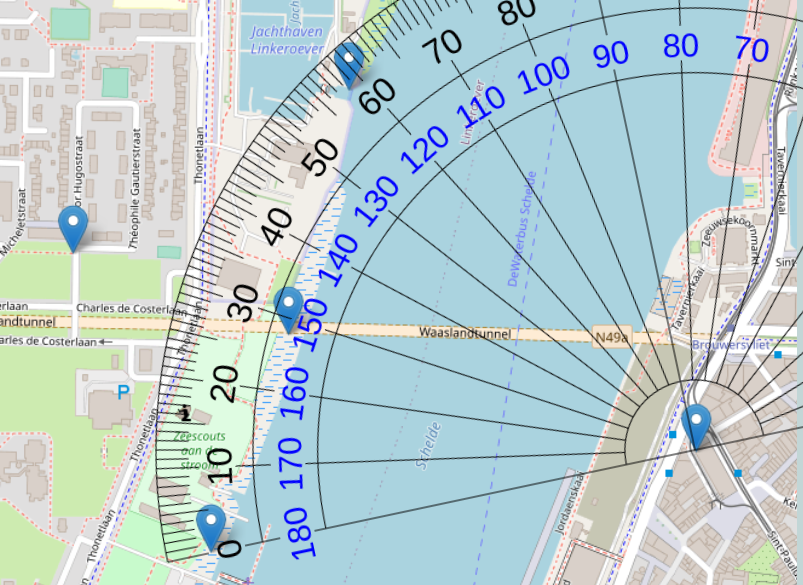

## Horizontal Angle 

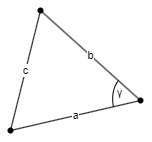

Law of cosines
$$ \gamma = \arccos\left(\frac{a^2+b^2-c^2}{2ab}\right) $$

In [4]:
def get_horizontal_angle():
    a = distance(antenna_coordinates, min_site_south_coordinates).m
    b = distance(antenna_coordinates, min_site_north_coordinates).m
    c = distance(min_site_south_coordinates, min_site_north_coordinates).m
    
    return math.acos((a**2 + b**2 - c**2) / (2*a*b))

In [5]:
horizontal_angle = get_horizontal_angle()

print(f'horizontal angle: {horizontal_angle:.2f} radians')
print(f'horizontal angle: {horizontal_angle*180/math.pi:.2f} degrees')

horizontal angle: 1.01 radians
horizontal angle: 57.68 degrees


**Comment:** added conversion to real degrees

## Vertical Angle

### Naive Vertical Angle

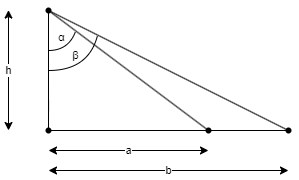

$$ tan(\alpha) = \frac{a}{h} $$
$$ tan(\beta) = \frac{b}{h} $$
$$ \rightarrow \beta - \alpha $$

In [22]:
def get_vertical_angle():
    a = distance(antenna_coordinates, min_site_coordinates).m
    b = distance(antenna_coordinates, max_site_coordinates).m
    h = antenna_building_height_m
    
    print(a, b)
    
    alpha = math.atan2(a, h)
    beta = math.atan2(b, h)
    
    return beta - alpha

In [23]:
vertical_angle = get_vertical_angle()

print(f'vertical angle: {vertical_angle:.2f} radians')
print(f'vertical angle: {vertical_angle*180/math.pi:.2f} degrees')

526.4812964391267 810.8842274094833
vertical angle: 0.01 radians
vertical angle: 0.76 degrees


**Comment:** Hmmmmm. That is very narrow.

Indeed, this is due to the 3dB beam width limit.  
Consider that we have an angle of 60 degrees in which we have a 3 dB loss.  
We can widen that angle to 120 degrees, but then the loss increases as well, to say 6 dB.  
Similarily, we can narrow the angle to 5 degrees in wich we have a near 0 dB loss.  

Above, we calculated for the near 0 dB loss and therefore got a narrow angle.

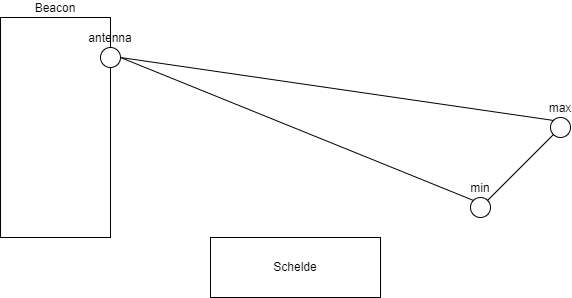

## Video Bandwidth

**Question:** Calculate the needed bandwidth to reliably stream a 4K image. Document your assumptions in terms of compression.

Data Rate = Resolution $\times$ Frame Rate $\times$ Color Depth $\times$ Compression Ratio
```
- Data Rate   [bits/seconds]
- Resolution  [pixels/frame]
- Frame Rate  [frames/second]
- Color Depth [bits/pixel]
- Compression Ratio
```

Assume a compression ratio of 1/150

**Sources:**
- The recommend internet connection speed for playing 4K video from netflix is 15 Mbps
    - https://help.netflix.com/en/node/306

In [ ]:
def get_data_rate_bps(resolution, frame_rate, color_depth, compression_ratio):
    return resolution * frame_rate * color_depth * compression_ratio

target_data_rate_bps = get_data_rate_bps(
    resolution=3840 * 2160,
    frame_rate=30,
    color_depth=10,
    compression_ratio=1/150
)

target_data_rate_mbps = target_data_rate_bps / 1_000_000

print(f'target data rate: {target_data_rate_mbps:.2f} Mbps')

**Question:** Break down the terms contributing to the e2e latency of your systems (from video capture to playback). 

**Answer:**

- Capture Latency: The time it takes for the camera to capture the video frames and send them to the encoder.

- Encoding Latency: The time it takes for the video to be encoded by the video encoder.

- Transmission Latency: The time it takes for the encoded video to be transmitted over the network to the viewer's device.

- Decoding Latency: The time it takes for the video to be decoded by the viewer's device.

- Display Latency: The time it takes for the decoded video to be displayed on the viewer's screen.

**Sources:**
- ChatGPT Mar 23 Version

**Question:** Make a choice as to which latency you are willing to accept. Why?

**Answer:**
Different use cases have varying levels of acceptable latency.

| Latency | Use Case                         |
|---------|----------------------------------|
| 45 s    | Conference Video Broadcasts      |
| 5 s     | Consumer IP Cameras, Live Sports |
| 500 ms  | Online auctions, security camera |
| 200 ms  | VOIP, video chat                 |

Our use case aligns best with the 500 ms latency.

**Sources:**
- https://www.rhombus.com/blog/guide-to-ultra-low-latency-ip-cameras-for-live-video-streaming/
- https://www.worldcast.group/low-latency-video-communication/

**Question:** Do you have requirements wrt. packet loss? Why?

**Answer:**

| Loss    | Rating     |
|---------|------------|
| <1%     | good       |
| 1%-2.5% | acceptable |
| 2.5%-5% | poor       |

I believe an "acceptable" rating to be reasonable.
So we aim for a maximum of 2.5% packet loss.

**Sources:**
- https://web.archive.org/web/20131010010244/http://sdu.ictp.it/pinger/pinger.html


**Comment:** But WHY?

We are creating a video stream designed for first responders, which differs from typical home entertainment streaming with voice.  
In the latter scenario, a high level of packet loss significantly degrades the experience, making sentences unintelligible and causing frustration.  
However, for first responders, an excessively distorted or buffering image would hinder their effectiveness in taking immediate action.  
Therefore, it is essential to strike a middle ground and we aim for a maximum of 2.5% packet loss.